## 1. American Sign Language (ASL)
<p>American Sign Language (ASL) is the primary language used by many deaf individuals in North America, and it is also used by hard-of-hearing and hearing individuals.  The language is as rich as spoken languages and employs signs made with the hand, along with facial gestures and bodily postures.</p>
<p></p>
<p>A lot of recent progress has been made towards developing computer vision systems that translate sign language to spoken language.  This technology  often relies on complex neural network architectures that can detect subtle patterns in streaming video.  However, as a first step, towards understanding how to build a translation system, we can reduce the size of the problem by translating individual letters, instead of sentences.</p>
<p><strong>In this notebook</strong>, we will train a convolutional neural network to classify images of American Sign Language (ASL) letters.  After loading, examining, and preprocessing the data, we will train the network and test its performance.</p>
<p>In the code cell below, we load the training and test data. </p>
<ul>
<li><code>x_train</code> and <code>x_test</code> are arrays of image data with shape <code>(num_samples, 3, 50, 50)</code>, corresponding to the training and test datasets, respectively.</li>
<li><code>y_train</code> and <code>y_test</code> are arrays of category labels with shape <code>(num_samples,)</code>, corresponding to the training and test datasets, respectively.</li>
</ul>

In [1]:
# Import packages and set numpy random seed
import numpy as np
np.random.seed(5) 
import tensorflow as tf
tf.set_random_seed(2)
from datasets import sign_language
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
from keras.utils import np_utils, to_categorical
from keras.preprocessing import image
from os import listdir
from os.path import isdir, join

def load_data(container_path='datasets', folders=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space'],
              size=2000, test_split=0.2, seed=0):
    """
    Loads sign language dataset.
    """
    
    filenames, labels = [], []

    for label, folder in enumerate(folders):
        folder_path = join(container_path, folder)
        images = [join(folder_path, d)
                     for d in sorted(listdir(folder_path))]
        labels.extend(len(images) * [label])
        filenames.extend(images)
    
    random.seed(seed)
    data = list(zip(filenames, labels))
    random.shuffle(data)
    data = data[:size]
    filenames, labels = zip(*data)

    
    # Get the images
    x = paths_to_tensor(filenames).astype('float32')/255
    # Store the one-hot targets
    y = np.array(labels)
    print(y)

    x_train = np.array(x[:int(len(x) * (1 - test_split))])
    y_train = np.array(y[:int(len(x) * (1 - test_split))])
    x_test = np.array(x[int(len(x) * (1 - test_split)):])
    y_test = np.array(y[int(len(x) * (1 - test_split)):])

    return (x_train, y_train), (x_test, y_test)


def path_to_tensor(img_path, size):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(size, size))
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor 
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, size=50):
    list_of_tensors = [path_to_tensor(img_path, size) for img_path in img_paths]
    return np.vstack(list_of_tensors)



Using TensorFlow backend.


## 2. Visualize the training data
<p>Now we'll begin by creating a list of string-valued labels containing the letters that appear in the dataset.  Then, we visualize the first several images in the training data, along with their corresponding labels.</p>

In [2]:
# Load pre-shuffled training and test datasets
(x_train, y_train), (x_test, y_test) = load_data()
print(y_train)

[17  3  1 ... 15  0 18]
[17  3  1 ... 15  3  7]


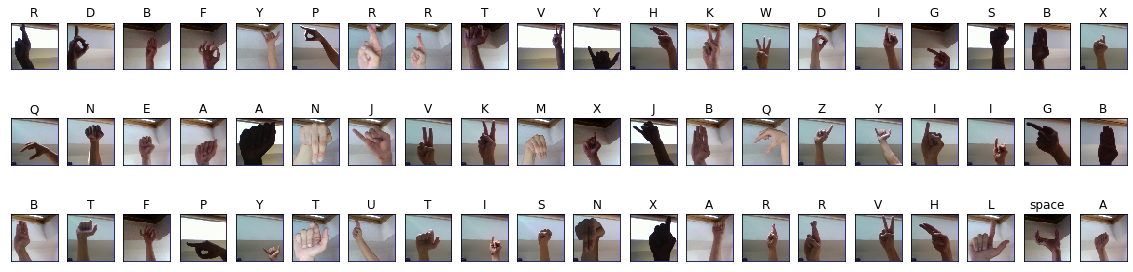

In [3]:
# Store labels of dataset
labels = ['A', 'B', 'C', 'D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(60):
    ax = fig.add_subplot(3,20 , i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

## 3. Examine the dataset
<p>Let's examine how many images of each letter can be found in the dataset.</p>
<p>Remember that dataset has already been split into training and test sets for you, where <code>x_train</code> and <code>x_test</code> contain the images, and <code>y_train</code> and <code>y_test</code> contain their corresponding labels.</p>
<p>Each entry in <code>y_train</code> and <code>y_test</code> is one of <code>0</code>, <code>1</code>, or <code>2</code>, corresponding to the letters <code>'A'</code>, <code>'B'</code>, and <code>'C'</code>, respectively.</p>
<p>We will use the arrays <code>y_train</code> and <code>y_test</code> to verify that both the training and test sets each have roughly equal proportions of each letter.</p>

In [4]:
# Number of A's in the training dataset
num_A_train = sum(y_train==0)
# Number of B's in the training dataset
num_B_train = sum(y_train==1)
# Number of C's in the training dataset
num_C_train = sum(y_train==2)
num_D_train = sum(y_train==3)

# Number of A's in the test dataset
num_A_test = sum(y_test==0)
# Number of B's in the test dataset
num_B_test = sum(y_test==1)
# Number of C's in the test dataset
num_C_test = sum(y_test==2)
num_D_test = sum(y_test==3)

# Print statistics about the dataset
print("Training set:")
print("\tA: {}, B: {}, C: {}, D: {}".format(num_A_train, num_B_train, num_C_train, num_D_train))
print("Test set:")
print("\tA: {}, B: {}, C: {}, D: {}".format(num_A_test, num_B_test, num_C_test, num_D_test))

Training set:
	A: 67, B: 70, C: 63, D: 74
Test set:
	A: 17, B: 10, C: 11, D: 11


## 4. One-hot encode the data
<p>Currently, our labels for each of the letters are encoded as categorical integers, where <code>'A'</code>, <code>'B'</code> and <code>'C'</code> are encoded as <code>0</code>, <code>1</code>, and <code>2</code>, respectively.  However, recall that Keras models do not accept labels in this format, and we must first one-hot encode the labels before supplying them to a Keras model.</p>
<p>This conversion will turn the one-dimensional array of labels into a two-dimensional array.</p>
<p></p>
<p>Each row in the two-dimensional array of one-hot encoded labels corresponds to a different image.  The row has a <code>1</code> in the column that corresponds to the correct label, and <code>0</code> elsewhere.  </p>
<p>For instance, </p>
<ul>
<li><code>0</code> is encoded as <code>[1, 0, 0]</code>, </li>
<li><code>1</code> is encoded as <code>[0, 1, 0]</code>, and </li>
<li><code>2</code> is encoded as <code>[0, 0, 1]</code>.</li>
</ul>

In [5]:
from keras.utils import np_utils

# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train)

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test)

## 5. Define the model
<p>Now it's time to define a convolutional neural network to classify the data.</p>
<p>This network accepts an image of an American Sign Language letter as input.  The output layer returns the network's predicted probabilities that the image belongs in each category.</p>

In [6]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=5, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(50, 50, 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(27, activation='softmax'))

# Summarize the model
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 5)         380       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 15)        1890      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 15)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 15)          5640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 15)          5640      
_________________________________________________________________
conv

## 6. Compile the model
<p>After we have defined a neural network in Keras, the next step is to compile it! </p>

In [7]:
# Compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## 7. Train the model
<p>Once we have compiled the model, we're ready to fit it to the training data.</p>

In [8]:
# Train the model
hist = model.fit(x_train, y_train_OH,
                validation_split=0.20,
                epochs=500,
                batch_size=64)

Instructions for updating:
Use tf.cast instead.
Train on 1280 samples, validate on 320 samples
Epoch 1/500
1280/1280 [==============================] - 5s 4ms/step - loss: 3.2949 - acc: 0.0406 - val_loss: 3.2868 - val_acc: 0.0437
Epoch 2/500
1280/1280 [==============================] - 3s 2ms/step - loss: 3.2761 - acc: 0.0461 - val_loss: 3.2508 - val_acc: 0.0750
Epoch 3/500
1280/1280 [==============================] - 3s 2ms/step - loss: 3.2266 - acc: 0.0828 - val_loss: 3.1844 - val_acc: 0.1094
Epoch 4/500
1280/1280 [==============================] - 3s 2ms/step - loss: 3.1201 - acc: 0.1063 - val_loss: 3.0474 - val_acc: 0.1500
Epoch 5/500
1280/1280 [==============================] - 3s 2ms/step - loss: 3.0027 - acc: 0.1313 - val_loss: 2.9234 - val_acc: 0.1844
Epoch 6/500
1280/1280 [==============================] - 3s 2ms/step - loss: 2.8839 - acc: 0.1703 - val_loss: 2.7860 - val_acc: 0.2250
Epoch 7/500
1280/1280 [==============================] - 3s 2ms/step - loss: 2.7236 - acc: 0.22

1280/1280 [==============================] - 2s 2ms/step - loss: 0.8602 - acc: 0.7336 - val_loss: 1.4672 - val_acc: 0.5375
Epoch 60/500
1280/1280 [==============================] - 3s 2ms/step - loss: 0.9277 - acc: 0.7078 - val_loss: 1.4448 - val_acc: 0.5500
Epoch 61/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.7693 - acc: 0.7500 - val_loss: 1.5087 - val_acc: 0.5312
Epoch 62/500
1280/1280 [==============================] - 3s 2ms/step - loss: 0.8308 - acc: 0.7305 - val_loss: 1.4575 - val_acc: 0.5406
Epoch 63/500
1280/1280 [==============================] - 3s 2ms/step - loss: 0.8010 - acc: 0.7469 - val_loss: 1.4479 - val_acc: 0.5437
Epoch 64/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.7680 - acc: 0.7508 - val_loss: 1.3880 - val_acc: 0.5594
Epoch 65/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.8121 - acc: 0.7266 - val_loss: 1.3158 - val_acc: 0.6062
Epoch 66/500
1280/1280 [==============================] - 2s 

Epoch 179/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.2370 - acc: 0.9578 - val_loss: 2.0221 - val_acc: 0.6844
Epoch 180/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.0159 - acc: 0.9984 - val_loss: 1.9769 - val_acc: 0.6844
Epoch 181/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1360 - acc: 0.9633 - val_loss: 2.0556 - val_acc: 0.6687
Epoch 182/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.0131 - acc: 1.0000 - val_loss: 2.0148 - val_acc: 0.7031
Epoch 183/500
1280/1280 [==============================] - 3s 2ms/step - loss: 0.1167 - acc: 0.9688 - val_loss: 2.2823 - val_acc: 0.6156
Epoch 184/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.0242 - acc: 0.9953 - val_loss: 1.9768 - val_acc: 0.6937
Epoch 185/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1356 - acc: 0.9688 - val_loss: 2.9025 - val_acc: 0.5687
Epoch 186/500
1280/1280 [================

Epoch 239/500
1280/1280 [==============================] - 3s 2ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 2.3461 - val_acc: 0.6813
Epoch 240/500
1280/1280 [==============================] - 3s 2ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 2.4113 - val_acc: 0.6719
Epoch 241/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 4.6491 - val_acc: 0.4688
Epoch 242/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1986 - acc: 0.9609 - val_loss: 2.2638 - val_acc: 0.6781
Epoch 243/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 2.3155 - val_acc: 0.6719
Epoch 244/500
1280/1280 [==============================] - 3s 2ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 2.3430 - val_acc: 0.6875
Epoch 245/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1161 - acc: 0.9656 - val_loss: 2.3896 - val_acc: 0.6781
Epoch 246/500
1280/1280 [================

Epoch 357/500
1280/1280 [==============================] - 2s 2ms/step - loss: 5.7288e-04 - acc: 1.0000 - val_loss: 2.6571 - val_acc: 0.6875
Epoch 358/500
1280/1280 [==============================] - 2s 2ms/step - loss: 2.0029e-04 - acc: 1.0000 - val_loss: 2.6399 - val_acc: 0.6844
Epoch 359/500
1280/1280 [==============================] - 3s 2ms/step - loss: 1.3241e-04 - acc: 1.0000 - val_loss: 2.6686 - val_acc: 0.6875
Epoch 360/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1645 - acc: 0.9742 - val_loss: 2.8269 - val_acc: 0.6625
Epoch 361/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.0029 - acc: 0.9984 - val_loss: 2.7672 - val_acc: 0.6781
Epoch 362/500
1280/1280 [==============================] - 3s 2ms/step - loss: 4.0802e-04 - acc: 1.0000 - val_loss: 2.7207 - val_acc: 0.6750
Epoch 363/500
1280/1280 [==============================] - 2s 2ms/step - loss: 1.9496e-04 - acc: 1.0000 - val_loss: 2.7169 - val_acc: 0.6719
Epoch 364/500
1280/12

1280/1280 [==============================] - 3s 2ms/step - loss: 1.1893e-05 - acc: 1.0000 - val_loss: 2.9089 - val_acc: 0.7125
Epoch 474/500
1280/1280 [==============================] - 2s 2ms/step - loss: 9.7996e-06 - acc: 1.0000 - val_loss: 2.9399 - val_acc: 0.7094
Epoch 475/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1305 - acc: 0.9719 - val_loss: 3.6684 - val_acc: 0.6594
Epoch 476/500
1280/1280 [==============================] - 2s 2ms/step - loss: 0.0110 - acc: 0.9984 - val_loss: 3.1946 - val_acc: 0.6813
Epoch 477/500
1280/1280 [==============================] - 2s 2ms/step - loss: 1.0108e-04 - acc: 1.0000 - val_loss: 3.1548 - val_acc: 0.6844
Epoch 478/500
1280/1280 [==============================] - 2s 2ms/step - loss: 4.8003e-05 - acc: 1.0000 - val_loss: 3.1253 - val_acc: 0.6875
Epoch 479/500
1280/1280 [==============================] - 3s 2ms/step - loss: 2.5230e-05 - acc: 1.0000 - val_loss: 3.0934 - val_acc: 0.6937
Epoch 480/500
1280/1280 [==========

## 8. Test the model
<p>To evaluate the model, we'll use the test dataset.  This will tell us how the network performs when classifying images it has never seen before!</p>
<p>If the classification accuracy on the test dataset is similar to the training dataset, this is a good sign that the model did not overfit to the training data.  </p>

In [9]:
# Obtain accuracy on test set
score = model.evaluate(x=x_test, 
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.705


9/9 [==============================] - 0s 6ms/step
[ 7  6  8  0 17 13 17  7 21]


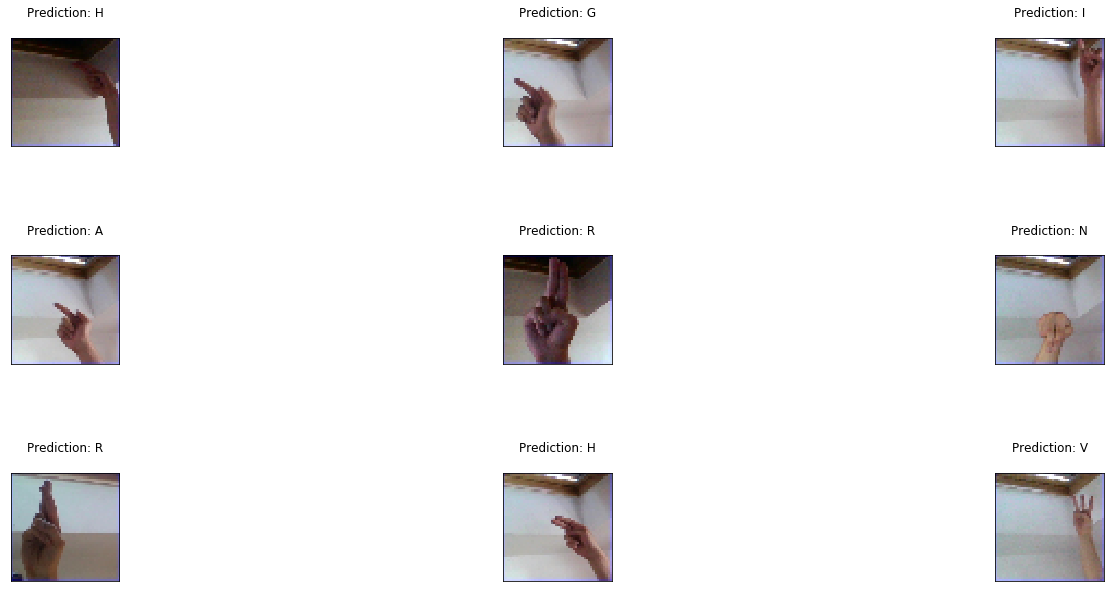

In [10]:
classes = range(0,27)

names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space']

# zip the names and classes to make a dictionary of class_labels
class_labels = dict(zip(classes, names))# generate batch of 9 images to predict
batch = x_test[100:109]
labels = np.argmax(y_test[100:109],axis=-1)

# make predictions
predictions = model.predict(batch, verbose = 1)

class_result = np.argmax(predictions,axis=-1)
print(class_result)

# create a grid of 3x3 images
fig, axs = plt.subplots(3, 3, figsize = (25, 10))
fig.subplots_adjust(hspace = 1)
axs = axs.flatten()

for i, img in enumerate(batch):

    # determine label for each prediction, set title
    for key, value in class_labels.items():
        if class_result[i] == key:
            #title = 'Prediction: {}\nActual:'.format(class_labels[key], class_labels[i])
            title = 'Prediction: {}\n'.format(class_labels[key])
            axs[i].set_title(title)
            axs[i].axes.get_xaxis().set_visible(False)
            axs[i].axes.get_yaxis().set_visible(False)
            
    # plot the image
    axs[i].imshow(img)
    
# show the plot
plt.show()

In [11]:
def load_data_m(container_path='datasets', folders=['cat'],
              size=2000, test_split=0.2, seed=0):
    """
    Loads sign language dataset.
    """
    
    filenames, labels = [], []

    for label, folder in enumerate(folders):
        folder_path = join(container_path, folder)
        images = [join(folder_path, d)
                     for d in sorted(listdir(folder_path))]
        images.sort()
        labels.extend(len(images) * [label])
        filenames.extend(images)
    
    data = list(zip(filenames, labels))
    data = data[:size]
    filenames, labels = zip(*data)

    
    # Get the images
    x = paths_to_tensor(filenames).astype('float32')/255
    # Store the one-hot targets
    y = np.array(labels)

    x_train = np.array(x[:int(len(x))])
    y_train = np.array(y[:int(len(x))])
    x_test = np.array(x[:int(len(x))])
    y_test = np.array(y[:int(len(x))])

    return (x_train, y_train), (x_test, y_test)


In [12]:
(x_train_m, y_train_m), (x_test_m, y_test_m) = load_data_m()

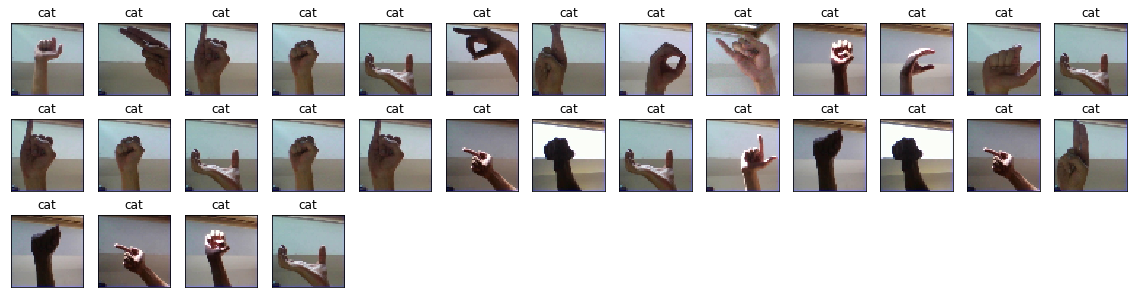

In [13]:
# Store labels of dataset
labels = ['cat']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(30):
    ax = fig.add_subplot(3,13, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train_m[i]))
    ax.set_title("{}".format(labels[y_train_m[i]]))
plt.show()

39/39 [==============================] - 0s 1ms/step
[19  7  8 18 26 15 17 14  9  4  2 19 26  8 18 26 18  8  6 13 26 11  0 13
  6 20  0  6  4 26 19 14 26 18 15  4  4  2  7]


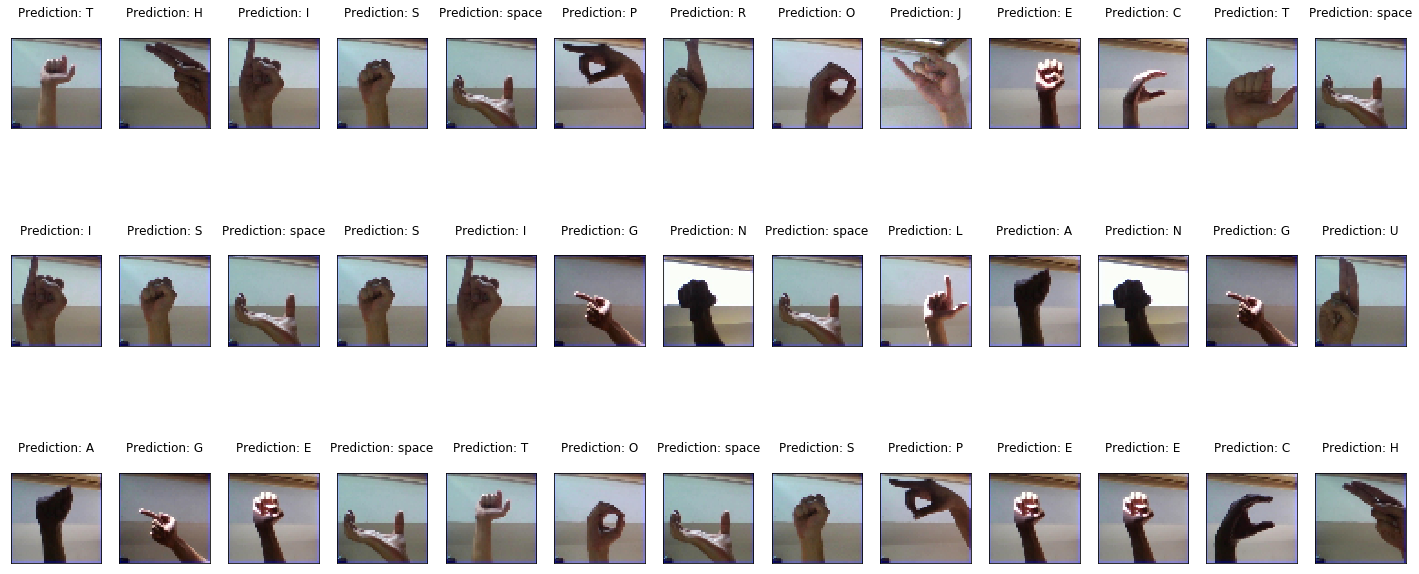

Predicted text from the Sign-Language Images is : 
THIS PROJECT IS SIGN LANGUAGE TO SPEECH


In [14]:
classes = range(0,27)
ans = ""

names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space']

# zip the names and classes to make a dictionary of class_labels
class_labels = dict(zip(classes, names)) # generate batch of 9 images to predict
batch = x_train_m
labels = np.argmax(y_train_m,axis=-1)

# make predictions
predictions = model.predict(batch, verbose = 1)

class_result = np.argmax(predictions,axis=-1)
print(class_result)

# create a grid of 3x3 images
fig, axs = plt.subplots(3,13, figsize = (25, 10))
fig.subplots_adjust(hspace = 1)
axs = axs.flatten()

for i, img in enumerate(batch):

    # determine label for each prediction, set title
    for key, value in class_labels.items():
        if class_result[i] == key:
            #title = 'Prediction: {}\nActual:'.format(class_labels[key], class_labels[i])
            title = 'Prediction: {}\n'.format(class_labels[key])
            if class_labels[key] == 'space':
                ans+=' '
            else:
                ans+=class_labels[key]
            axs[i].set_title(title)
            axs[i].axes.get_xaxis().set_visible(False)
            axs[i].axes.get_yaxis().set_visible(False)
            
    # plot the image
    axs[i].imshow(img)
    
# show the plot
plt.show()
print("Predicted text from the Sign-Language Images is : ")
print(ans)

In [6]:
import os
from gtts import gTTS 
language = 'en'
     
# Passing the text and language to the engine,  
# here we have marked slow=False. Which tells  
# the module that the converted audio should  
# have a high speed 
myobj = gTTS(text=ans, lang=language, slow=False) 
  
# Saving the converted audio in a mp3 file named 
# welcome  
myobj.save("output.mp3") 
  
# Playing the converted file 
os.system("mpg321 output.mp3") 

32512

In [9]:
from pygame import mixer
mixer.init()
mixer.music.load("output.mp3")
mixer.music.play()

## 9. Visualize mistakes
<p>Hooray!  Our network gets very high accuracy on the test set!  </p>
<p>The final step is to take a look at the images that were incorrectly classified by the model.  Do any of the mislabeled images look relatively difficult to classify, even to the human eye?  </p>
<p>Sometimes, it's possible to review the images to discover special characteristics that are confusing to the model.  However, it is also often the case that it's hard to interpret what the model had in mind!</p>

## 9. Visualize mistakes
<p>Hooray!  Our network gets very high accuracy on the test set!  </p>
<p>The final step is to take a look at the images that were incorrectly classified by the model.  Do any of the mislabeled images look relatively difficult to classify, even to the human eye?  </p>
<p>Sometimes, it's possible to review the images to discover special characteristics that are confusing to the model.  However, it is also often the case that it's hard to interpret what the model had in mind!</p>